In [1]:
import einops
import numpy as np

In [2]:
# Helper function. Can be ignored. Taken from: https://github.com/arogozhnikov/einops/blob/main/docs/utils/__init__.py
def display_np_arrays_as_images():
    import IPython
    import PIL.Image
    def np_to_png(a):
        if 2 <= len(a.shape) <= 3:
            return PIL.Image.fromarray(np.array(np.clip(a, 0, 1) * 255, dtype="uint8"))._repr_png_()
        else:
            return PIL.Image.fromarray(np.zeros([1, 1], dtype="uint8"))._repr_png_()

    def np_to_text(obj, p, cycle):
        if len(obj.shape) < 2:
            print(repr(obj))
        if 2 <= len(obj.shape) <= 3:
            pass
        else:
            print(f"<array of shape {obj.shape}>")

    IPython.get_ipython().display_formatter.formatters["image/png"].for_type(np.ndarray, np_to_png)
    IPython.get_ipython().display_formatter.formatters["text/plain"].for_type(np.ndarray, np_to_text)

display_np_arrays_as_images()

### Load Some test images

In [3]:
images = np.load("./test_images.npy", allow_pickle=False)
print(images.shape, images.dtype)

(6, 96, 96, 3) float64


Thus, 6 images of shape 96, 96 with 3 channels are loaded.

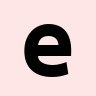

In [4]:
images[0]

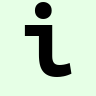

In [5]:
images[1]

#### Rearrange example
- images[0] is een 3D tensor van een afbeelding met shape (h, w, c):
  - h = hoogte
  - w = breedte
  - c = aantal kanalen (bijv. RGB → 3)
- "h w c -> w h c" zegt tegen einops:
  - Neem de huidige assen (h, w, c)
  - Wissel de hoogte en breedte om
  - Het aantal kanalen (c) blijft hetzelfde
  - Het resultaat is een nieuwe tensor met shape (w, h, c).

💡 In simpele woorden: je draait de afbeelding of verwisselt rijen en kolommen, zonder de kanalen te veranderen.

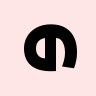

In [6]:
einops.rearrange(images[0], "h w c -> w h c")

# 0 0 0 -> 0 0 0
# 95 0 0 -> 0 95 0

In [7]:
print(einops.rearrange(np.arange(12).reshape(3,4), "h w -> w h"))

[[ 0  4  8]
 [ 1  5  9]
 [ 2  6 10]
 [ 3  7 11]]


#### Composition of axes with `rearrange`

- images is een batch van afbeeldingen, shape (b, h, w, c):
  - b = aantal afbeeldingen in de batch
  - h = hoogte van elke afbeelding
  - w = breedte van elke afbeelding
  - c = aantal kanalen
- "b h w c -> (b h) w c" zegt:
  - Combineer de batchdimensie b met de hoogte h tot één nieuwe as (b*h)
  - Breedte w en kanalen c blijven hetzelfde
- Resultaat: een enkele lange afbeelding waarin alle batchafbeeldingen onder elkaar gestapeld zijn.
  - Als elke afbeelding hoogte h=96 heeft en je b=6 afbeeldingen hebt, wordt de nieuwe hoogte 6*96 = 576.

💡 In korte woorden: alle afbeeldingen in de batch worden verticaal aaneengeregen tot één grote afbeelding.

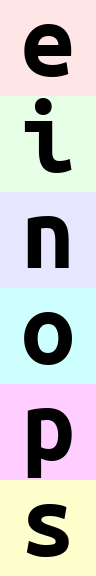

In [8]:
# Create a single image with height 6 * 96
einops.rearrange(images, "b h w c -> (b h) w c")

```python
einops.rearrange(images, "b h w c -> h (b w) c")
```

- images heeft shape (b, h, w, c):
  - b = aantal afbeeldingen in de batch
  - h = hoogte van elke afbeelding
  - w = breedte van elke afbeelding
  - c = aantal kanalen
- "b h w c -> h (b w) c" betekent:
  - Hoogte h blijft hetzelfde
  - Breedte w van elke afbeelding wordt gecombineerd met de batchdimensie b → nieuwe breedte = b * w
  - Kanalen c blijven hetzelfde
- Resultaat: een enkele afbeelding waarin alle afbeeldingen horizontaal naast elkaar zijn geplaatst.
  - Als w=96 en b=6, wordt de nieuwe breedte 6*96 = 576.

💡 In korte woorden: alle afbeeldingen worden naast elkaar geplakt tot één lange brede afbeelding.

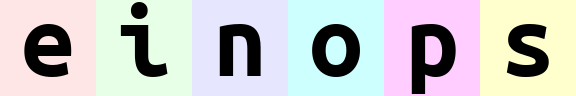

In [9]:
# Create a new image with width 6 * 96
# 2 0 0 0 * 0
einops.rearrange(images, "b h w c -> h (b w) c")

#### Decomposition of axes with `rearrange`

Represent an axis as the combination of new axes

In [10]:
einops.rearrange(images, "(b1 b2) h w c -> b1 b2 h w c", b1=2).shape

(2, 3, 96, 96, 3)

A combination of decomposition and composition of axes.

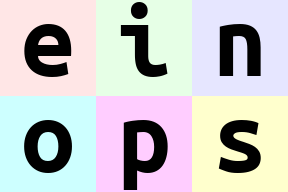

In [11]:
einops.rearrange(images, "(b1 b2) h w c -> (b1 h) (b2 w) c", b1=2)

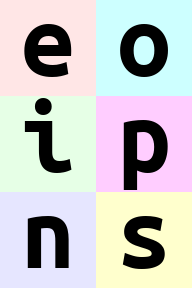

In [12]:
einops.rearrange(images, "(b1 b2) h w c -> (b2 h) (b1 w) c", b1=2)

#### `reduce`

Matrix X:

|   | 0 | 1 | 2 | 3 |
|---|---|---|---|---|
| 0 | 0 | 1 | 2 | 3 |
| 1 | 4 | 5 | 6 | 7 |
| 2 | 8 | 9 |10 |11 |

Gemiddelde per kolom:

| Col 0 | Col 1 | Col 2 | Col 3 |
|-------|-------|-------|-------|
|   4   |   5   |   6   |   7   |

Berekening van het gemiddelde per kolom:

Col 0 = (0 + 4 + 8) / 3 = 4  
Col 1 = (1 + 5 + 9) / 3 = 5  
Col 2 = (2 + 6 +10) / 3 = 6  
Col 3 = (3 + 7 +11) / 3 = 7

In [13]:
X = np.arange(12).reshape(3, 4).astype(np.float32)
print(X)

[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]]


Compute the mean of each column.

In [14]:
einops.reduce(X, "rows cols -> cols", reduction="mean")

array([4., 5., 6., 7.], dtype=float32)
<array of shape (4,)>


Compute the mean of each row.

In [15]:
einops.reduce(X, "rows cols -> rows", reduction="mean")

array([1.5, 5.5, 9.5], dtype=float32)
<array of shape (3,)>


In [16]:
# Keep dimensions
einops.reduce(X, "rows cols -> rows 1", reduction="mean").shape

(3, 1)

In [17]:
# Mean over all elements
einops.reduce(X, "rows cols -> ", reduction="mean")

np.float32(5.5)

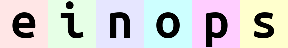

In [18]:
# Max pooling over 2*2 window and rearranging
einops.reduce(images, "b (h h2) (w w2) c -> h (b w) c", "max", h2=2, w2=2)

In [19]:
# Stride is equal to window size
einops.reduce(images, "b (h h2) (w w2) c -> b h w c", "max", h2=2, w2=2).shape

(6, 48, 48, 3)

#### `repeat`

In [20]:
X = np.arange(4)
print(X)

[0 1 2 3]


In [21]:
print(einops.repeat(X, "w -> h w", h = 4))

[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]


In [22]:
# Shortcut and different placement of new axis
print(einops.repeat(X, "w -> w 3"))

[[0 0 0]
 [1 1 1]
 [2 2 2]
 [3 3 3]]


In [23]:
X = np.arange(4).reshape(2, 2)
print(X)
print(einops.repeat(X, "h w -> h (2 w)"))

[[0 1]
 [2 3]]
[[0 1 0 1]
 [2 3 2 3]]


Order of the axes matters. Repeat each element two times.

In [24]:
print(einops.repeat(X, "h w -> h (w 2)"))

[[0 0 1 1]
 [2 2 3 3]]
